In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
# Load data
train_df = pd.read_csv('custom_train.csv')
test_df = pd.read_csv('custom_test.csv')

# Prepare the data
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(train_df['conversation'].values)

X_train = tokenizer.texts_to_sequences(train_df['conversation'].values)
X_train = pad_sequences(X_train, maxlen=max_len)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['class'])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_test)))

In [3]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(train_df['class'])), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 747,397
Trainable params: 747,397
Non-trainable params: 0
_________________________________________________________________
None


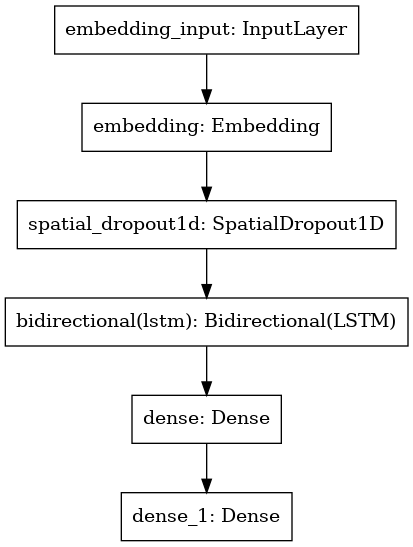

In [4]:
plot_model(model)

In [5]:
batch_size = 64
epochs = 5

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.2, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
51/51 [==============================] - 40s 700ms/step - loss: 1.3798 - accuracy: 0.3636 - val_loss: 1.0937 - val_accuracy: 0.4554
Epoch 2/5
51/51 [==============================] - 35s 695ms/step - loss: 0.8443 - accuracy: 0.6213 - val_loss: 0.7570 - val_accuracy: 0.6696
Epoch 3/5
51/51 [==============================] - 35s 690ms/step - loss: 0.4791 - accuracy: 0.8119 - val_loss: 0.5875 - val_accuracy: 0.7698
Epoch 4/5
51/51 [==============================] - 35s 683ms/step - loss: 0.2515 - accuracy: 0.9162 - val_loss: 0.5843 - val_accuracy: 0.7884
Epoch 5/5
51/51 [==============================] - 35s 683ms/step - loss: 0.1553 - accuracy: 0.9483 - val_loss: 0.5950 - val_accuracy: 0.8119


In [6]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Predict and print classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

32/32 - 2s - loss: 0.6175 - accuracy: 0.8198
Test Loss: 0.617519199848175
Test Accuracy: 0.8198019862174988
              precision    recall  f1-score   support

       갈취 대화       0.85      0.81      0.83       215
   기타 괴롭힘 대화       0.79      0.68      0.73       217
       일반 대화       0.98      0.99      0.98       206
 직장 내 괴롭힘 대화       0.75      0.90      0.82       179
       협박 대화       0.73      0.74      0.73       193

    accuracy                           0.82      1010
   macro avg       0.82      0.82      0.82      1010
weighted avg       0.82      0.82      0.82      1010



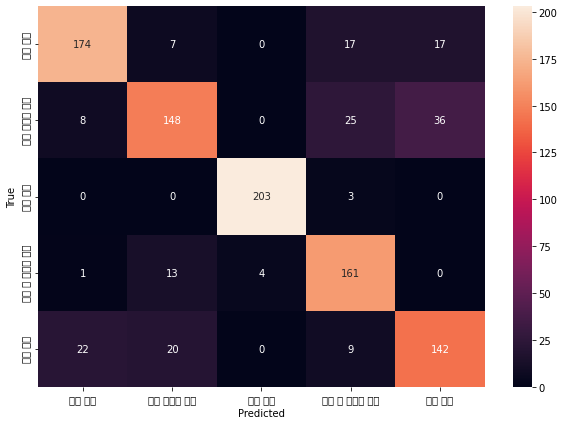

In [22]:
# Generate and plot the confusion matrix
class_list = list(map(str, label_encoder.classes_))
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_list, yticklabels=class_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
print(class_list)

['갈취 대화', '기타 괴롭힘 대화', '일반 대화', '직장 내 괴롭힘 대화', '협박 대화']
